In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import shap

c:\Users\Haran Perumal S L\miniconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np

def auto_detect_plateaus(
    df, 
    temp_col='Ch3 TC Temp (Chart) (°C)', 
    diff_thresh=0.05, 
    window=180, 
    plateau_gap=5, 
    tol=0.09,
    cluster_tol=240,
    max_temp=None
):
    """
    For each cluster, returns both:
      - longest plateau (by time)
      - highest plateau (by mean temperature)
    Output: 
      means (list), 
      plateau_info (dict: {cluster_mean: {'longest': DataFrame, 'highest': DataFrame}})
    """
    # 0. Slice df up to ramp-up maximum
    if max_temp is not None:
        ramp_end_idx = df[temp_col][df[temp_col] >= max_temp].index[0]
    else:
        ramp_end_idx = df[temp_col].idxmax()
    df_rampup = df.loc[:ramp_end_idx].copy()

    # 1. Find stable regions (where temp doesn't change much)
    diff = df_rampup[temp_col].diff().abs().fillna(0)
    stable = diff < diff_thresh

    # 2. Group contiguous stable regions
    plateaus = []
    start = None
    for i, is_stable in enumerate(stable):
        if is_stable and start is None:
            start = i
        elif not is_stable and start is not None:
            if (i - start) >= window:
                plateaus.append((start, i-1))
            start = None
    if start is not None and (len(df_rampup) - start) >= window:
        plateaus.append((start, len(df_rampup)-1))

    # 3. Merge nearby plateaus (if any)
    merged_plateaus = []
    prev_end = -plateau_gap*3
    for s, e in plateaus:
        if s - prev_end <= plateau_gap and merged_plateaus:
            merged_plateaus[-1] = (merged_plateaus[-1][0], e)
        else:
            merged_plateaus.append((s, e))
        prev_end = e

    # 4. For each plateau, get mean temperature and DataFrame
    detected = []
    for s, e in merged_plateaus:
        plateau_temp = df_rampup[temp_col].iloc[s:e+1].mean()
        plateau_df = df_rampup.iloc[s:e+1]
        mask = plateau_df[temp_col].between(plateau_temp - tol, plateau_temp + tol)
        extracted = plateau_df[mask].copy()
        if not extracted.empty:
            detected.append((plateau_temp, extracted, s, e))

    # 5. Cluster mean temperatures & keep both longest and highest plateau per cluster
    if not detected:
        return [], {}
    detected = sorted(detected, key=lambda x: x[0])
    clusters = []
    cluster = [detected[0]]
    for entry in detected[1:]:
        if abs(entry[0] - cluster[-1][0]) <= cluster_tol:
            cluster.append(entry)
        else:
            clusters.append(cluster)
            cluster = [entry]
    clusters.append(cluster)

    means = []
    plateau_info = {}
    for cl in clusters:
        # Longest plateau (by number of rows)
        longest = max(cl, key=lambda x: len(x[1]))
        # Highest plateau (by plateau mean temperature)
        highest = max(cl, key=lambda x: x[0])
        cluster_center = np.mean([x[0] for x in cl])
        means.append(round(cluster_center, 3))
        plateau_info[round(cluster_center, 3)] = {
            'longest': longest[1],
            'highest': highest[1]
        }

    return means, plateau_info


In [5]:
import os

df = pd.read_csv('./Corrected Data/baseline.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    #os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    #combined.to_csv('./Corrected Data/Plateau Data/baseline.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")


In [6]:
df = pd.read_csv('./Corrected Data/cycle_1.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_1.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")


In [224]:
df = pd.read_csv('./Corrected Data/cycle_2.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_2.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [225]:
df = pd.read_csv('./Corrected Data/cycle_3.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_3.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [226]:
df = pd.read_csv('./Corrected Data/cycle_4.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_4.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [227]:
df = pd.read_csv('./Corrected Data/cycle_5.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_5.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [228]:
df = pd.read_csv('./Corrected Data/cycle_6.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_6.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [229]:
df = pd.read_csv('./Corrected Data/cycle_7.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_7.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [230]:
df = pd.read_csv('./Corrected Data/cycle_8.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_8.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [231]:
df = pd.read_csv('./Corrected Data/cycle_9.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_9.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [232]:
df = pd.read_csv('./Corrected Data/cycle_10.csv')
plateau_means, plateau_data = auto_detect_plateaus(df)

out_rows = []
for mean, plateau_dict in plateau_data.items():
    for kind in ['longest', 'highest']:
        plateau = plateau_dict[kind].copy()
        plateau['plateau_mean'] = mean
        plateau['plateau_type'] = kind
        out_rows.append(plateau)

if out_rows:
    combined = pd.concat(out_rows, ignore_index=True)
    # Ensure output folder exists
    os.makedirs('./Corrected Data/Plateau Data/', exist_ok=True)
    combined.to_csv('./Corrected Data/Plateau Data/cycle_10.csv', index=False)
else:
    print("No plateaus detected; nothing to save.")

In [253]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import glob

T_refs = np.array([597, 890, 1180])

def interpolate_emf_at_temp(df, temp_col='Ch3 TC Temp (Chart) (°C)', emf_col='Ch3 TC EMF (mV)', T_refs=None):
    # Remove duplicates for cleaner interpolation
    clean = df.drop_duplicates(subset=[temp_col])
    x = clean[temp_col].values   # Temperature
    y = clean[emf_col].values    # EMF
    if len(x) < 2:
        return np.full_like(T_refs, np.nan, dtype=float)
    interp_fn = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    return interp_fn(T_refs)

# Your calibration function
def convert_emf_to_temp_table_interpolation_Channel_3_New(measured_emf_mv: float) -> float | str:
    calibration_data = [
        (0.00000, 0), (0.05518, 10), (0.11275, 20), (0.17258, 30), (0.23454, 40),
        (0.29852, 50), (0.36442, 60), (0.43213, 70), (0.50155, 80), (0.57259, 90),
        (0.64517, 100), (0.71920, 110), (0.79461, 120), (0.87132, 130), (0.94927, 140),
        (1.02840, 150), (1.10863, 160), (1.18991, 170), (1.27219, 180), (1.35542, 190),
        (1.43955, 200), (1.52453, 210), (1.61032, 220), (1.69689, 230), (1.78419, 240),
        (1.87218, 250), (1.96085, 260), (2.05014, 270), (2.14005, 280), (2.23053, 290),
        (2.32157, 300), (2.41313, 310), (2.50521, 320), (2.59777, 330), (2.69079, 340),
        (2.78427, 350), (2.87819, 360), (2.97252, 370), (3.06725, 380), (3.16238, 390),
        (3.25790, 400), (3.35378, 410), (3.45002, 420), (3.54661, 430), (3.64355, 440),
        (3.74083, 450), (3.83844, 460), (3.93638, 470), (4.03463, 480), (4.13321, 490),
        (4.23210, 500), (4.33130, 510), (4.43082, 520), (4.53064, 530), (4.63077, 540),
        (4.73121, 550), (4.83195, 560), (4.93300, 570), (5.03436, 580), (5.13603, 590),
        (5.23802, 600), (5.34031, 610), (5.44292, 620), (5.54584, 630), (5.64908, 640),
        (5.75264, 650), (5.85653, 660), (5.96074, 670), (6.06528, 680), (6.17014, 690),
        (6.27534, 700), (6.38088, 710), (6.48675, 720), (6.59297, 730), (6.69952, 740),
        (6.80642, 750), (6.91366, 760), (7.02125, 770), (7.12919, 780), (7.23747, 790),
        (7.34611, 800), (7.45509, 810), (7.56443, 820), (7.67411, 830), (7.778415, 840),
        (7.89453, 850), (8.00526, 860), (8.11634, 870), (8.22777, 880), (8.33953, 890),
        (8.45164, 900), (8.56409, 910), (8.67688, 920), (8.79000, 930), (8.90346, 940),
        (9.01724, 950), (9.13135, 960), (9.24579, 970), (9.36055, 980), (9.47563, 990),
        (9.59103, 1000), (9.70675, 1010), (9.82278, 1020), (9.93914, 1030), (10.05581, 1040),
        (10.17280, 1050), (10.29012, 1060), (10.40775, 1070), (10.52566, 1080), (10.64383, 1090),
        (10.76225, 1100), (10.88090, 1110), (10.99979, 1120), (11.11890, 1130), (11.23822, 1140),
        (11.35775, 1150), (11.47747, 1160), (11.59737, 1170), (11.71744, 1180), (11.83768, 1190),
        (11.95807, 1200)
    ]
    min_emf = calibration_data[0][0]
    max_emf = calibration_data[-1][0]
    if measured_emf_mv < min_emf:
        emf1, temp1 = calibration_data[0]
        emf2, temp2 = calibration_data[1]
        if (emf2 - emf1) == 0: return temp1
        return temp1 + (measured_emf_mv - emf1) * (temp2 - temp1) / (emf2 - emf1)
    if measured_emf_mv > max_emf:
        emf1, temp1 = calibration_data[-2]
        emf2, temp2 = calibration_data[-1]
        if (emf2 - emf1) == 0: return temp1
        return temp1 + (measured_emf_mv - emf1) * (temp2 - temp1) / (emf2 - emf1)
    for i in range(len(calibration_data) - 1):
        emf1, temp1 = calibration_data[i]
        emf2, temp2 = calibration_data[i+1]
        if emf1 <= measured_emf_mv <= emf2:
            if (emf2 - emf1) == 0:
                return temp1
            return temp1 + (measured_emf_mv - emf1) * (temp2 - temp1) / (emf2 - emf1)
    return np.nan

# 1. Interpolate baseline EMFs at T_refs
baseline = pd.read_csv('./Corrected Data/baseline.csv')
baseline_emfs = interpolate_emf_at_temp(baseline, T_refs=T_refs)

# 2. For each cycle, interpolate EMF at T_refs, calculate drift, and convert to ΔT
drift_summary = []
for f in glob.glob('./Corrected Data/cycle_*.csv'):
    cyclename = f.split('/')[-1].split('\\')[-1].replace('.csv', '')
    df = pd.read_csv(f)
    cycle_emfs = interpolate_emf_at_temp(df, T_refs=T_refs)
    emf_drifts = cycle_emfs - baseline_emfs
    # Convert EMF drift at T_ref to equivalent ΔT using calibration function
    for T, cyc_emf, base_emf, dr_emf in zip(T_refs, cycle_emfs, baseline_emfs, emf_drifts):
        # "Reference" EMF at T_ref (from baseline)
        ref_emf = base_emf
        delta_T = convert_emf_to_temp_table_interpolation_Channel_3_New(dr_emf)
        drift_summary.append({
            'cycle': cyclename,
            'T_ref': T,
            'cycle_emf': cyc_emf,
            'baseline_emf': base_emf,
            'emf_drift': dr_emf,
            'temp_drift': delta_T
        })

# 3. Save or analyze
drift_df = pd.DataFrame(drift_summary)
drift_df.to_csv('./Corrected Data/drift_interp_summary.csv', index=False)


In [267]:
from scipy.stats import zscore
def compute_drift_robust(
    cycle_df,
    baseline_df,
    emf_col='Ch3 TC EMF (mV)',
    temp_col='Ch3 TC Temp (Chart) (°C)',
    label='Cycle',
    round_emf=5
) -> pd.DataFrame:
    """
    Computes temperature drift between a given cycle and the baseline using interpolation on EMF.

    Parameters:
    ----------
    cycle_df : pd.DataFrame
        DataFrame of the current cycle.
    baseline_df : pd.DataFrame
        DataFrame of the baseline cycle.
    emf_col : str
        Column name for EMF (mV).
    temp_col : str
        Column name for Temperature (°C).
    label : str
        Label for output drift column.
    round_emf : int
        Decimal rounding precision for EMF values to prevent duplication noise.

    Returns:
    -------
    pd.DataFrame
        DataFrame with EMF, baseline temperature, interpolated cycle temperature, and drift.
    """

    # Step 1: Drop NaNs and ensure numeric
    cycle_df = cycle_df[[emf_col, temp_col]].dropna().copy()
    baseline_df = baseline_df[[emf_col, temp_col]].dropna().copy()

    cycle_df[emf_col] = pd.to_numeric(cycle_df[emf_col], errors='coerce')
    cycle_df[temp_col] = pd.to_numeric(cycle_df[temp_col], errors='coerce')
    baseline_df[emf_col] = pd.to_numeric(baseline_df[emf_col], errors='coerce')
    baseline_df[temp_col] = pd.to_numeric(baseline_df[temp_col], errors='coerce')

    # Step 2: Round and remove duplicates
    cycle_df[emf_col] = cycle_df[emf_col].round(round_emf)
    baseline_df[emf_col] = baseline_df[emf_col].round(round_emf)

    cycle_df.drop_duplicates(subset=emf_col, inplace=True)
    baseline_df.drop_duplicates(subset=emf_col, inplace=True)

    # Step 3: Sort both by EMF
    cycle_df.sort_values(by=emf_col, inplace=True)
    baseline_df.sort_values(by=emf_col, inplace=True)

    # Step 4: Trim to overlapping EMF range
    emf_min = max(cycle_df[emf_col].min(), baseline_df[emf_col].min())
    emf_max = min(cycle_df[emf_col].max(), baseline_df[emf_col].max())

    cycle_trimmed = cycle_df[(cycle_df[emf_col] >= emf_min) & (cycle_df[emf_col] <= emf_max)].copy()
    baseline_trimmed = baseline_df[(baseline_df[emf_col] >= emf_min) & (baseline_df[emf_col] <= emf_max)].copy()

    # Step 5: Interpolate cycle temperature on baseline EMF axis
    interp_cycle_temp = np.interp(
        x=baseline_trimmed[emf_col].values,
        xp=cycle_trimmed[emf_col].values,
        fp=cycle_trimmed[temp_col].values
    )

    # Step 6: Calculate drift
    drift = interp_cycle_temp - baseline_trimmed[temp_col].values

    # Step 7: Construct result DataFrame
    drift_df = pd.DataFrame({
        emf_col: baseline_trimmed[emf_col].values,
        f'{temp_col} (Baseline)': baseline_trimmed[temp_col].values,
        f'{temp_col} ({label})': interp_cycle_temp,
        f'Drift ({label}) (°C)': drift
    })

    #filter out extreme outliers using Z-score
    drift_values = drift_df[f'Drift ({label}) (°C)']
    if drift_values.std() > 0:
        drift_df = drift_df[np.abs(zscore(drift_values)) < 3]

    return drift_df


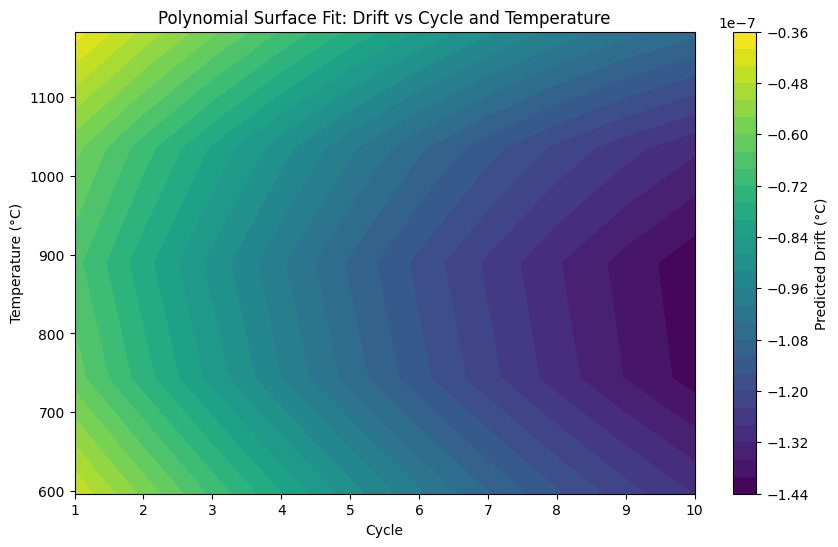

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1. Load the drift matrix (from previous step)
df = pd.read_csv('./Corrected Data/drift_matrix_robust.csv')

# 2. Prepare input variables (cycle, baseline_temp) and target (drift)
# You can also use 'emf' as the axis if you prefer
X = df[['cycle', 'baseline_temp']].values
y = df['drift'].values

# 3. Polynomial surface fitting
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

model = LinearRegression().fit(X_poly, y)

# 4. Predict on a regular grid for visualization and forecasting
cycles = np.arange(df['cycle'].min(), df['cycle'].max() + 1)
temps = np.linspace(df['baseline_temp'].min(), df['baseline_temp'].max(), 5)
grid_cycles, grid_temps = np.meshgrid(cycles, temps)
X_grid = np.column_stack([grid_cycles.ravel(), grid_temps.ravel()])
X_grid_poly = poly.transform(X_grid)
drift_pred = model.predict(X_grid_poly).reshape(grid_temps.shape)

# 5. Visualization: surface/contour plot
plt.figure(figsize=(10, 6))
cp = plt.contourf(grid_cycles, grid_temps, drift_pred, 30, cmap='viridis')
plt.colorbar(cp, label='Predicted Drift (°C)')
plt.xlabel('Cycle')
plt.ylabel('Temperature (°C)')
plt.title('Polynomial Surface Fit: Drift vs Cycle and Temperature')
plt.show()


In [4]:
drift_cycle_1 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_1.csv')
drift_cycle_2 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_2.csv')
drift_cycle_3 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_3.csv')
drift_cycle_4 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_4.csv')
drift_cycle_5 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_5.csv')
drift_cycle_6 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_6.csv')
drift_cycle_7 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_7.csv')
drift_cycle_8 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_8.csv')
drift_cycle_9 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_9.csv')
drift_cycle_10 = pd.read_csv('./Corrected Data/Drift_cycles_DB/cycle_10.csv')

In [5]:
cycles = [drift_cycle_1, drift_cycle_2, drift_cycle_3, drift_cycle_4, drift_cycle_5, drift_cycle_6, drift_cycle_7, drift_cycle_8, drift_cycle_9, drift_cycle_10]
plateau_windows = [
    (596.5, 598),     # for "600°C" plateau
    (889, 893),     # for "900°C" plateau
    (1180, 1185),   # for "1200°C" plateau
]

plateau_labels = ["~596°C", "~891°C", "~1183°C"]

drift_at_plateau = {label: [] for label in plateau_labels}

for i, cycle_df in enumerate(cycles, 1):
    for (t_low, t_high), label in zip(plateau_windows, plateau_labels):
        # Find rows within the plateau window
        mask = (cycle_df[f'Ch3 TC Temp (Chart) (°C) (Cycle {i})'] >= t_low) & (cycle_df[f'Ch3 TC Temp (Chart) (°C) (Cycle {i})'] <= t_high)
        # If 'Drift (Cycle X) (°C)' column exists
        drift_col = f'Drift (Cycle {i}) (°C)'
        # Compute the mean (or median) drift in this window
        mean_drift = cycle_df.loc[mask, drift_col].mean()
        drift_at_plateau[label].append(mean_drift)

import pandas as pd
drift_plateau_df = pd.DataFrame(drift_at_plateau)
drift_plateau_df.index = [f'Cycle {i}' for i in range(1, len(cycles)+1)]
print(drift_plateau_df)

                ~596°C        ~891°C       ~1183°C
Cycle 1   4.736952e-15  0.000000e+00 -6.747918e-09
Cycle 2  -4.736952e-15 -1.019613e-15 -2.030195e-08
Cycle 3   0.000000e+00  1.529419e-15 -4.858504e-08
Cycle 4   4.736952e-15 -2.039226e-15 -3.909003e-15
Cycle 5   0.000000e+00  1.529419e-15  3.920236e-15
Cycle 6   0.000000e+00 -4.384302e-08 -7.940835e-08
Cycle 7   4.736952e-15 -5.098064e-16 -5.735733e-08
Cycle 8   4.736952e-15  3.058839e-15 -6.747924e-09
Cycle 9  -9.473903e-15  5.098064e-16 -6.832270e-08
Cycle 10  4.736952e-15  0.000000e+00  1.303001e-15


In [6]:
def compute_dTdt(df, temp_col='Baseline Temp (°C)'):
    # Calculate rate of change using central difference
    df = df.copy()
    df['dT_dt'] = df[temp_col].diff().fillna(0)
    return df


In [7]:
def tag_wing_plateau(df, temp_col='Baseline Temp (°C)', dt_col='dT_dt', threshold=0.03):
    df = df.copy()
    df['region'] = np.where(df[dt_col].abs() > threshold, 'wing', 'plateau')
    return df


In [8]:
for i in range(1, 11):
    df = globals()[f'drift_cycle_{i}']
    # Compute dT/dt
    df = compute_dTdt(df, temp_col=f'Ch3 TC Temp (Chart) (°C) (Cycle {i})')
    # Tag regions
    df = tag_wing_plateau(df, temp_col=f'Ch3 TC Temp (Chart) (°C) (Cycle {i})', dt_col='dT_dt', threshold=0.03)
    # Save back with new name for clarity
    globals()[f'drift_cycle_{i}_tagged'] = df

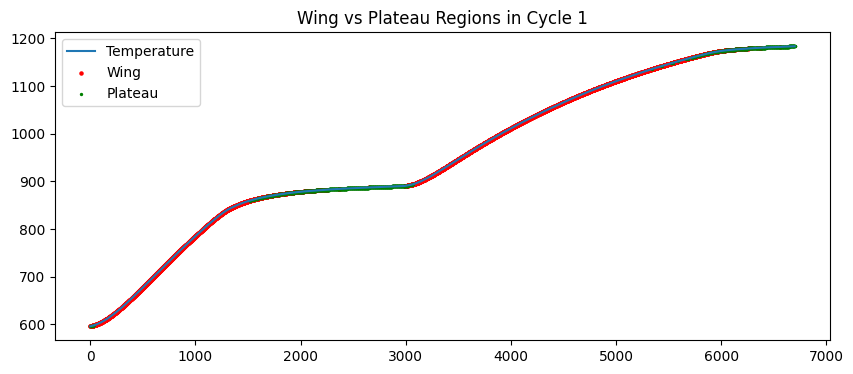

In [9]:
plt.figure(figsize=(10,4))
df = drift_cycle_1_tagged
plt.plot(df['Ch3 TC Temp (Chart) (°C) (Cycle 1)'], label='Temperature')
plt.scatter(df.index[df['region']=='wing'], df.loc[df['region']=='wing', 'Ch3 TC Temp (Chart) (°C) (Cycle 1)'], color='red', s=5, label='Wing')
plt.scatter(df.index[df['region']=='plateau'], df.loc[df['region']=='plateau', 'Ch3 TC Temp (Chart) (°C) (Cycle 1)'], color='green', s=2, label='Plateau')
plt.legend()
plt.title("Wing vs Plateau Regions in Cycle 1")
plt.show()

In [10]:
wing_dfs = []

for i in range(1, 11):
    df = globals()[f'drift_cycle_{i}_tagged']
    # Filter to wing only
    wings = df[df['region'] == 'wing'].copy()
    wings['cycle'] = i  # Track cycle number
    # Standardize column names for modeling
    wings.rename(columns={
        f'Ch3 TC Temp (Chart) (°C) (Cycle {i})': 'Temp_C',
        'Ch3 TC EMF (mV)': 'EMF_mV',
        f'Drift (Cycle {i}) (°C)': 'Drift_C'
    }, inplace=True)
    # Keep only columns of interest
    wing_dfs.append(wings[['cycle', 'Temp_C', 'EMF_mV', 'Drift_C', 'dT_dt', 'period'] + 
                          ([col for col in wings.columns if 'Timestamp' in col] if 'Timestamp' in wings.columns else [])])

# Combine all cycles’ wings into a single modeling dataframe
wings_all = pd.concat(wing_dfs, ignore_index=True)


In [11]:
wings_all

,cycle,Temp_C,EMF_mV,Drift_C,dT_dt,period
0,1,596.311403,5.2004,0.000000e+00,0.068634,46.000000
1,1,596.389842,5.2012,0.000000e+00,0.078439,200.000000
2,1,596.429062,5.2016,0.000000e+00,0.039220,261.000000
3,1,596.566330,5.2030,0.000000e+00,0.068634,438.000000
4,1,596.634964,5.2037,0.000000e+00,0.068634,499.000000
...,...,...,...,...,...,...
48202,10,1180.163007,11.7194,-2.273737e-13,0.041583,15871.666667
48203,10,1180.196274,11.7198,0.000000e+00,0.033267,15873.000000
48204,10,1180.279441,11.7208,0.000000e+00,0.033267,15880.000000
48205,10,1180.337658,11.7215,-2.273737e-13,0.033267,15883.500000


In [ ]:
# Start with your wings_all
df = wings_all.copy()

# Normalize period to [0, 1] for each cycle (important for sequence-based models)
df['period_norm'] = df.groupby('cycle')['period'].transform(lambda x: x / x.max())

# Optional: Ramp rate is already present as dT_dt
# If you want squared terms or interactions for ML/DL:
df['EMF_mV_sq'] = df['EMF_mV'] ** 2
df['Temp_C_sq'] = df['Temp_C'] ** 2
df['EMF_Temp_interaction'] = df['EMF_mV'] * df['Temp_C']

# Arrange columns for modeling
model_features = ['cycle', 'period', 'period_norm', 'EMF_mV', 'Temp_C', 'dT_dt',
                  'EMF_mV_sq', 'Temp_C_sq', 'EMF_Temp_interaction', 'Drift_C']

df_model = df[model_features].copy()


In [13]:
df_model

,cycle,period,period_norm,EMF_mV,Temp_C,dT_dt,EMF_mV_sq,Temp_C_sq,EMF_Temp_interaction,Drift_C
0,1,46.000000,0.004106,5.2004,596.311403,0.068634,27.044160,3.555873e+05,3101.057821,0.000000e+00
1,1,200.000000,0.017851,5.2012,596.389842,0.078439,27.052481,3.556808e+05,3101.942847,0.000000e+00
2,1,261.000000,0.023295,5.2016,596.429062,0.039220,27.056643,3.557276e+05,3102.385407,0.000000e+00
3,1,438.000000,0.039093,5.2030,596.566330,0.068634,27.071209,3.558914e+05,3103.934615,0.000000e+00
4,1,499.000000,0.044538,5.2037,596.634964,0.068634,27.078494,3.559733e+05,3104.709363,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
48202,10,15871.666667,0.987351,11.7194,1180.163007,0.041583,137.344336,1.392785e+06,13830.802348,-2.273737e-13
48203,10,15873.000000,0.987434,11.7198,1180.196274,0.033267,137.353712,1.392863e+06,13831.664293,0.000000e+00
48204,10,15880.000000,0.987869,11.7208,1180.279441,0.033267,137.377153,1.393060e+06,13833.819273,0.000000e+00
48205,10,15883.500000,0.988087,11.7215,1180.337658,0.033267,137.393562,1.393197e+06,13835.327858,-2.273737e-13


In [98]:
df_model_clean = df_model.dropna().reset_index(drop=True)

In [99]:
df_model_clean.describe()

,cycle,period,period_norm,EMF_mV,Temp_C,dT_dt,EMF_mV_sq,Temp_C_sq,EMF_Temp_interaction,Drift_C
count,48207.000000,48207.000000,48207.000000,48207.000000,48207.000000,48207.000000,48207.000000,4.820700e+04,48207.000000,48207.000000
mean,5.501525,8091.175585,0.622049,8.961319,940.928369,0.117038,83.938885,9.141242e+05,8755.242948,0.000002
std,2.873719,4240.063263,0.297798,1.906231,169.642529,0.063349,33.077456,3.085921e+05,3205.693016,0.000146
min,1.000000,-2403.000000,-0.209710,5.200400,596.311403,0.033267,27.044160,3.555873e+05,3101.057821,-0.001104
25%,3.000000,4653.937500,0.324086,7.629250,825.909920,0.071794,58.205456,6.821272e+05,6301.073338,0.000000
50%,6.000000,8415.687500,0.776371,9.133000,960.144180,0.106082,83.411689,9.218768e+05,8768.996799,0.000000
75%,8.000000,11931.445175,0.872369,10.692400,1094.101503,0.153396,114.327418,1.197058e+06,11698.570912,0.000000
max,10.000000,16075.000000,1.000000,11.744100,1182.217232,5.597465,137.923885,1.397638e+06,13884.077397,0.013545


In [100]:
df_model_clean.head()

,cycle,period,period_norm,EMF_mV,Temp_C,dT_dt,EMF_mV_sq,Temp_C_sq,EMF_Temp_interaction,Drift_C
0,1,46.0,0.004106,5.2004,596.311403,0.068634,27.044160,355587.289442,3101.057821,0.0
1,1,200.0,0.017851,5.2012,596.389842,0.078439,27.052481,355680.843809,3101.942847,0.0
2,1,261.0,0.023295,5.2016,596.429062,0.039220,27.056643,355727.625608,3102.385407,0.0
3,1,438.0,0.039093,5.2030,596.566330,0.068634,27.071209,355891.386128,3103.934615,0.0
4,1,499.0,0.044538,5.2037,596.634964,0.068634,27.078494,355973.280520,3104.709363,0.0


In [101]:
df_model_clean = df_model_clean[df_model_clean['cycle'] != 4]

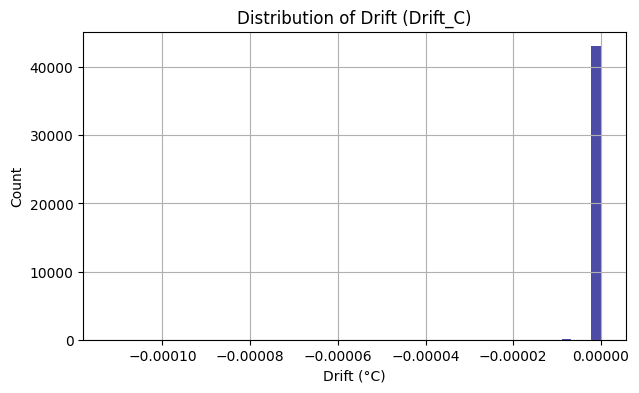

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df_model_clean['Drift_C'], bins=50, color='navy', alpha=0.7)
plt.title("Distribution of Drift (Drift_C)")
plt.xlabel("Drift (°C)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


<Figure size 700x400 with 0 Axes>

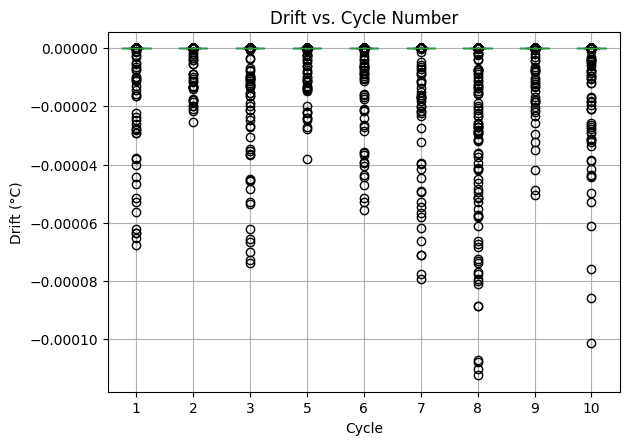

In [103]:
plt.figure(figsize=(7,4))
df_model_clean.boxplot(column='Drift_C', by='cycle', grid=True)
plt.title("Drift vs. Cycle Number")
plt.xlabel("Cycle")
plt.ylabel("Drift (°C)")
plt.suptitle("")
plt.show()


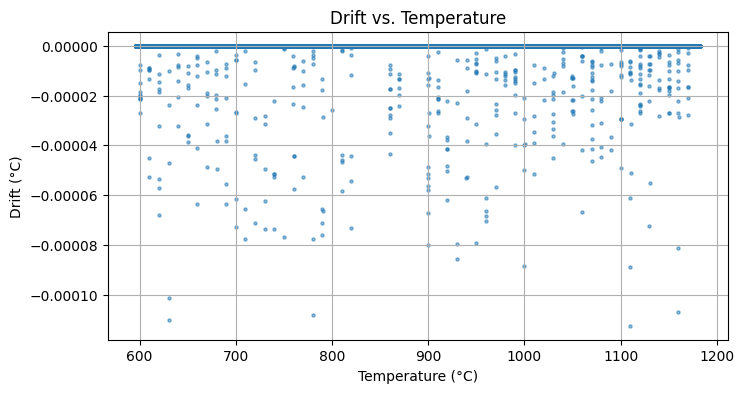

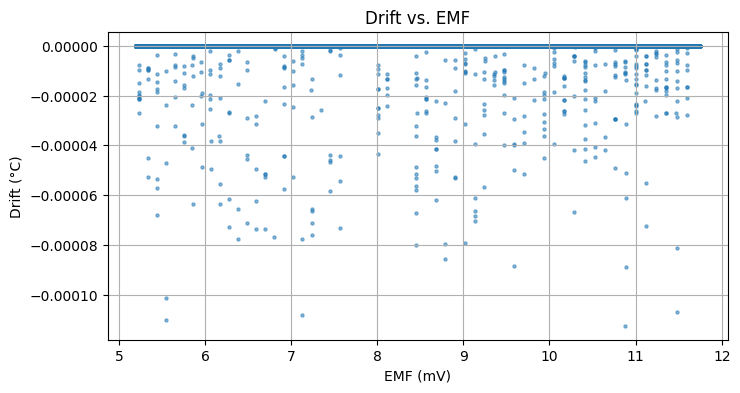

In [104]:
plt.figure(figsize=(8,4))
plt.scatter(df_model_clean['Temp_C'], df_model_clean['Drift_C'], s=5, alpha=0.5)
plt.title("Drift vs. Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Drift (°C)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(df_model_clean['EMF_mV'], df_model_clean['Drift_C'], s=5, alpha=0.5)
plt.title("Drift vs. EMF")
plt.xlabel("EMF (mV)")
plt.ylabel("Drift (°C)")
plt.grid(True)
plt.show()


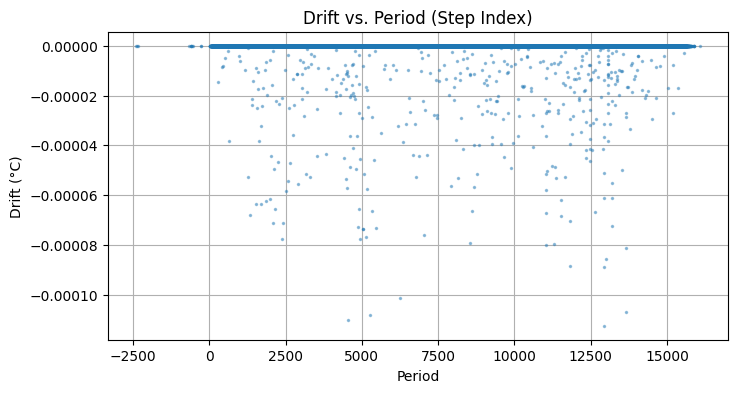

In [105]:
plt.figure(figsize=(8,4))
plt.plot(df_model_clean['period'], df_model_clean['Drift_C'], '.', alpha=0.4, markersize=3)
plt.title("Drift vs. Period (Step Index)")
plt.xlabel("Period")
plt.ylabel("Drift (°C)")
plt.grid(True)
plt.show()


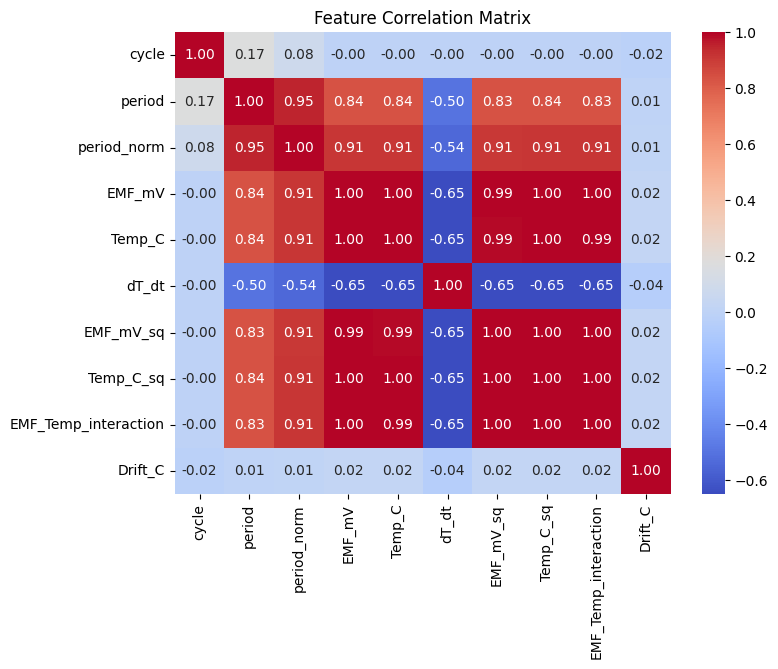

In [106]:
import seaborn as sns

corr = df_model_clean.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


In [121]:
from sklearn.model_selection import train_test_split

# Choose your features for modeling
features = ['EMF_mV_sq','Temp_C_sq','EMF_Temp_interaction', 'period',	'period_norm',	'EMF_mV'	,'Temp_C']

X = df_model_clean[features]
y = df_model_clean['Drift_C']

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [133]:
results = []

In [134]:
# Baseline
drift_mean = y_train.mean()
y_pred_baseline = np.full(y_test.shape, drift_mean)
results.append({
    "Model": "Baseline",
    "MAE": mean_absolute_error(y_test, y_pred_baseline),
    "MSE": mean_squared_error(y_test, y_pred_baseline)
})

In [135]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train[['Temp_C']], y_train)
y_pred_lr = lr.predict(X_test[['Temp_C']])
results.append({
    "Model": "Linear Regression",
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "MSE": mean_squared_error(y_test, y_pred_lr)
})

In [136]:
# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_lr = LinearRegression().fit(X_poly_train, y_train)
y_pred_poly = poly_lr.predict(X_poly_test)
results.append({
    "Model": "Polynomial (deg=3)",
    "MAE": mean_absolute_error(y_test, y_pred_poly),
    "MSE": mean_squared_error(y_test, y_pred_poly)
})

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
cv_rf = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_rf.fit(X_train, y_train)

print("Best RF Params:", cv_rf.best_params_)
print("Best CV MAE:", -cv_rf.best_score_)

Best RF Params: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MAE: 4.2336015575594544e-07


In [137]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append({
    "Model": "Random Forest",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "MSE": mean_squared_error(y_test, y_pred_rf)
})

In [129]:
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_reg = xgb.XGBRegressor(random_state=42)
cv_xgb = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_xgb.fit(X_train, y_train)

print("Best XGB Params:", cv_xgb.best_params_)
print("Best CV MAE:", -cv_xgb.best_score_)

Best XGB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV MAE: 4.770610808440795e-07


In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
xgb_model = xgb.XGBRegressor(
    n_estimators=100, max_depth=3, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
results.append({
    "Model": "XGBoost",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "MSE": mean_squared_error(y_test, y_pred_xgb)
})

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

def create_ffnn(hidden1=64, hidden2=32, dropout_rate=0.1, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

regressor = KerasRegressor(
    model=create_ffnn,
    verbose=0,
    # Expose all tunable params at construction time!
    hidden1=64, hidden2=32, dropout_rate=0.1, learning_rate=0.001
)



In [150]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [153]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=40, batch_size=64, verbose=1)

Epoch 1/40


c:\Users\Haran Perumal S L\miniconda3\envs\tfenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0205 - mae: 0.0738 - val_loss: 1.1289e-04 - val_mae: 0.0086
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4315e-04 - mae: 0.0139 - val_loss: 2.1060e-05 - val_mae: 0.0034
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8650e-04 - mae: 0.0088 - val_loss: 8.9245e-06 - val_mae: 0.0025
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1085e-04 - mae: 0.0064 - val_loss: 6.7115e-06 - val_mae: 0.0020
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8278e-05 - mae: 0.0051 - val_loss: 6.3325e-06 - val_mae: 0.0019
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6432e-05 - mae: 0.0042 - val_loss: 2.4977e-06 - val_mae: 0.0013
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7086e-05 - mae: 0.0038 - val_loss: 1.1065e-05 - val_mae: 0.0025
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5362e-05 - mae: 0.0030 - val_loss: 3.4335e-06 - val_mae: 0.0017
Epoch 9

In [155]:
y_pred_nn = model.predict(X_test_scaled).flatten()
results.append({
    "Model": "Feed Forward NN",
    "MAE": mean_absolute_error(y_test, y_pred_nn),
    "MSE": mean_squared_error(y_test, y_pred_nn)
})

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


In [156]:
results_df = pd.DataFrame(results)

In [157]:
results_df

,Model,MAE,MSE
0,Baseline,4.786088e-07,1.082741e-11
1,Linear Regression,4.784602e-07,1.081484e-11
2,Polynomial (deg=3),4.804864e-07,1.081347e-11
3,Random Forest,4.602221e-07,1.022570e-11
4,XGBoost,4.782798e-07,1.082740e-11
5,Feed Forward NN,1.540100e-04,3.514548e-08


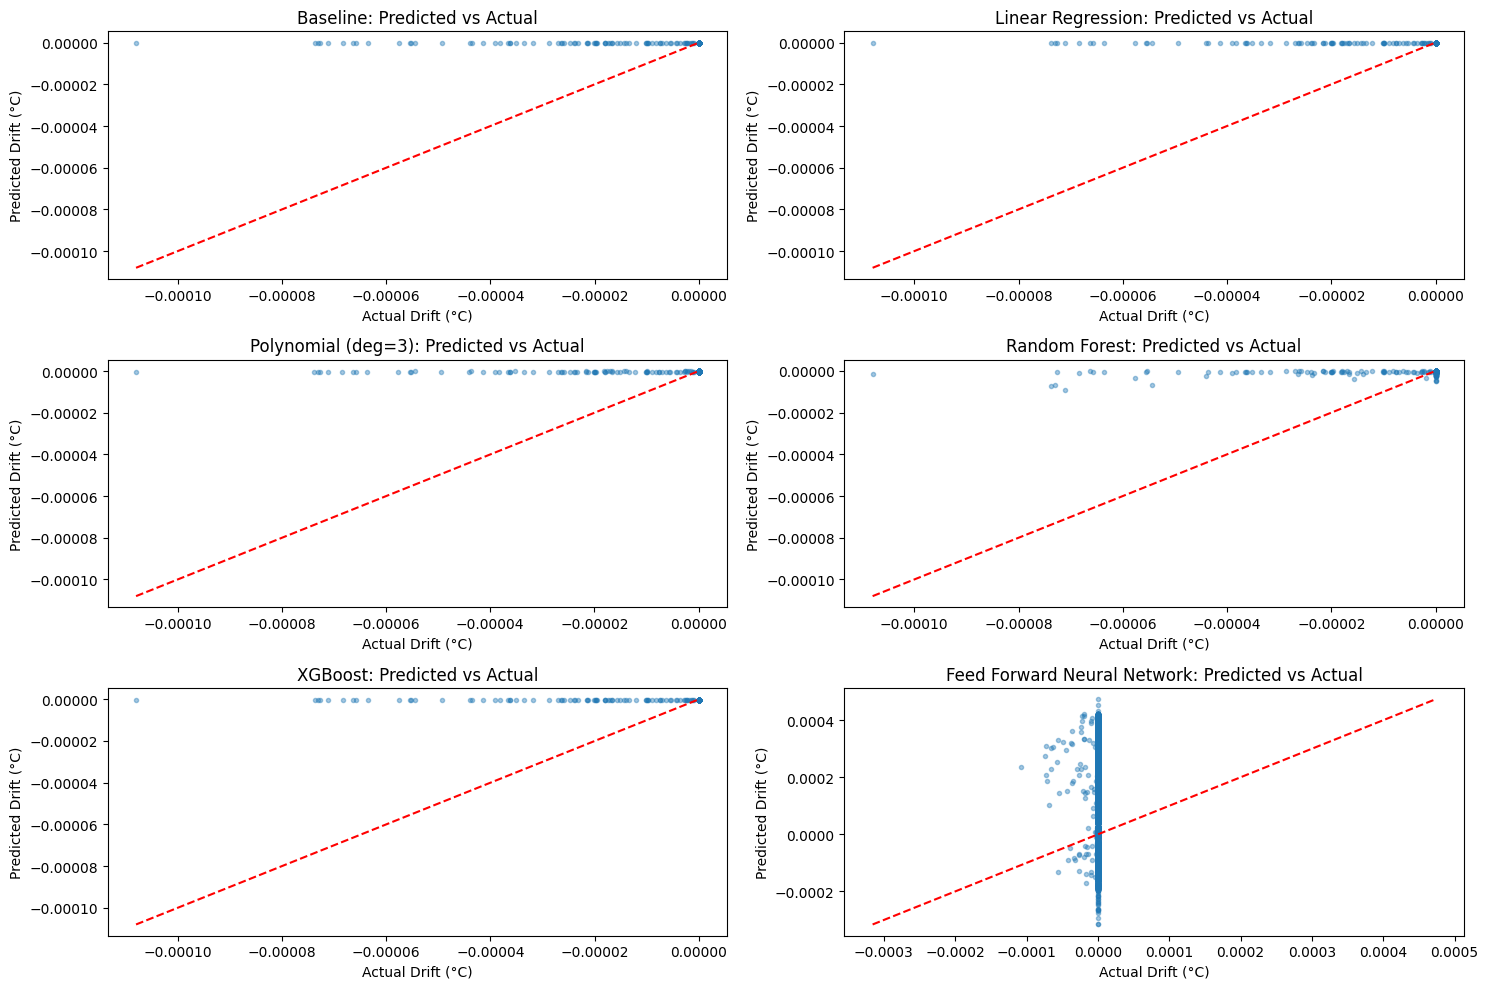

In [158]:
models = [
    ("Baseline", y_pred_baseline),
    ("Linear Regression", y_pred_lr),
    ("Polynomial (deg=3)", y_pred_poly),
    ("Random Forest", y_pred_rf),
    ("XGBoost", y_pred_xgb),
    ("Feed Forward Neural Network", y_pred_nn)
]

plt.figure(figsize=(15, 10))
for i, (name, y_pred) in enumerate(models, 1):
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, s=9, alpha=0.4)
    plt.xlabel('Actual Drift (°C)')
    plt.ylabel('Predicted Drift (°C)')
    plt.title(f'{name}: Predicted vs Actual')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.show()


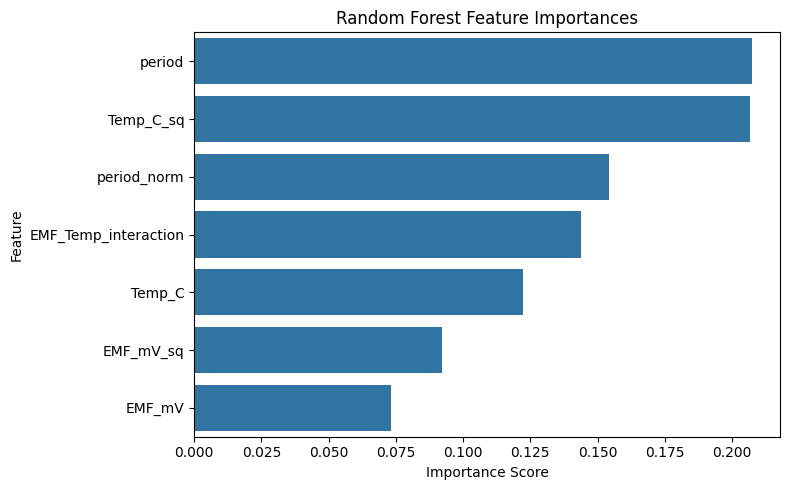

In [161]:
import seaborn as sns

# Get feature importances
feat_importance = rf.feature_importances_
features = features

# Sort by importance
sorted_idx = np.argsort(feat_importance)[::-1]
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importance[sorted_idx], y=np.array(features)[sorted_idx])
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


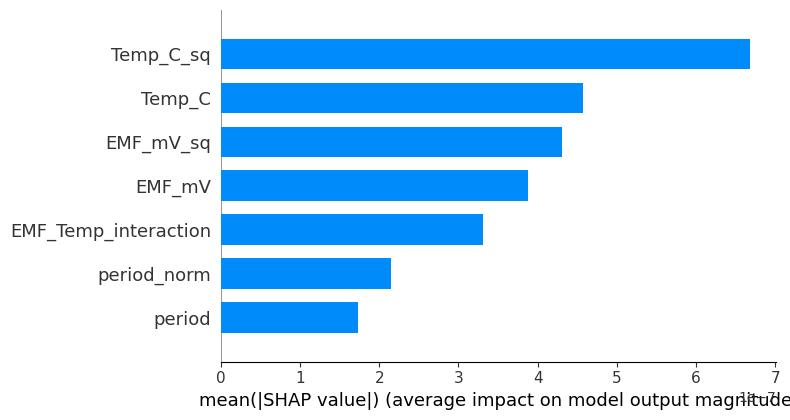

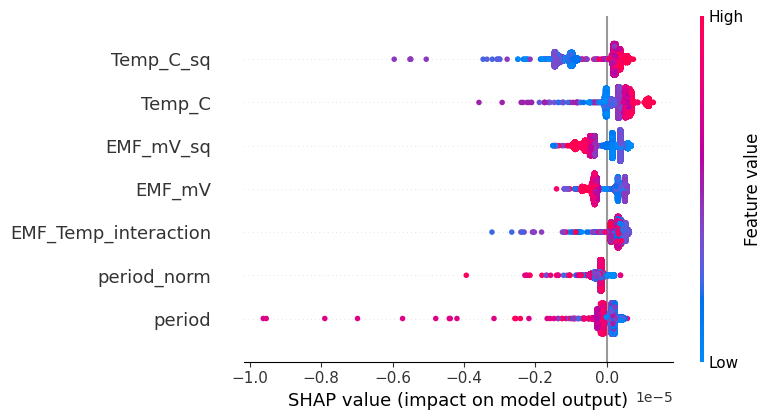

In [160]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_train, show=True)    

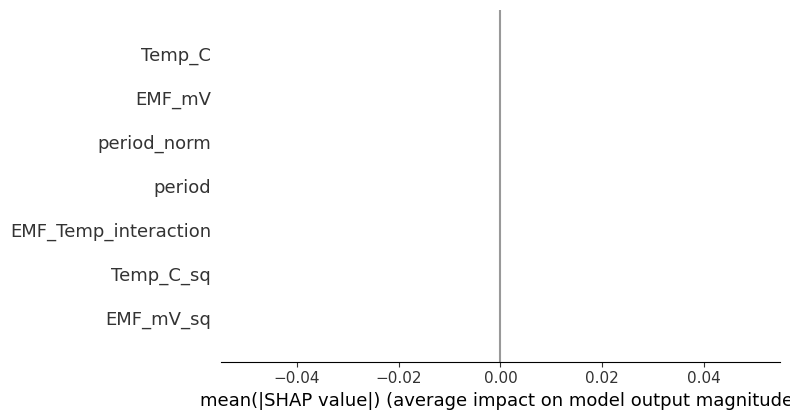

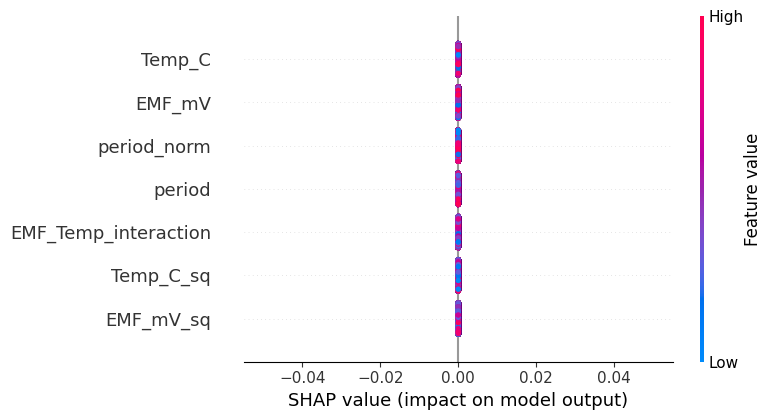

In [163]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_train, show=True)   